# Plot experiment resultts
In this notebook the results for the baseline in topical decoding are analysed

## Overview
1. Imports
    - 1.1. Import libraries
    - 1.3. Import NEWTS dataset
    - 1.4. Import LDA model

2. Helper functions and parameters

3. Evaluate baseline experiment results

4. Evaluate logits reweighting experiment results

# 1. Imports

## 1.1 Import libraries

In [100]:
import os, sys
root_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())))
data_dir = os.path.join(root_dir, 'data')
sys.path.append(root_dir)

In [101]:
import json
import matplotlib.pyplot as plt
import numpy as np
from utils.evaluation_utils import calculate_scores
from matplotlib.patches import Patch

In [102]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [103]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 2. Helper functions and Parameters

In [104]:
FONT_SIZE_LABEL = 12
FONT_SIZE_LEGEND = 12
FONT_SIZE_SUPTITLE = 16
FONT_SIZE_TITLE = 14
FONT_SIZE_TICKS = 10
FIG_SIZE = (8, 4)
METHOD_DICT = {
    'mauve': 'MAUVE',
    'bert': 'BERT',
    'avg_rouge': 'ROUGE',
    'rouge1': 'ROUGE-1',
    'rouge2': 'ROUGE-2',
    'rougeL': 'ROUGE-L',
    'stem' : 'Stemmed',
    'lemmatize' : 'Lemmatized',
    'dict' : 'Dictionary',
    'tokenize' : 'Tokenized',
}
DPI = 300
PLOT_FORMAT = 'pdf'
MODEL_NAME_DICT = {
    'gemma_2b' : '2B Gemma',
    'llama_8b' : '8B Llama3',
}
Y_SUBTITLE = 0.94

# 3. Evaluate baseline experiment results

## 3.1 Import baseline experiment results

In [105]:
FILE_NAME = 'baseline_llama_8b_25_80_90_1' # e,g, 'baseline_gemma_2b_4_80_90_1'
EXPERIMENT_NAME = 'baseline'

In [106]:
experiment_results_file_path = os.path.join(data_dir, f'results_{EXPERIMENT_NAME}', f'{FILE_NAME}.json')
with open(experiment_results_file_path, 'r', encoding='utf-8') as f:
    experiment_results = json.load(f)
print(json.dumps(experiment_results, indent=4))

{
    "experiment_information": {
        "EXPERIMENT_CONFIG": {
            "experiment_name": "baseline",
            "model_alias": "llama_8b"
        },
        "GENERATION_CONFIG": {
            "min_new_tokens": 80,
            "max_new_tokens": 90,
            "num_beams": 1,
            "do_sample": true,
            "top_p": 0.95,
            "top_k": 50
        },
        "DATASET_CONFIG": {
            "dataset_name": "newts_train",
            "num_articles": 25,
            "batch_size": 1,
            "num_workers": 0,
            "shuffle": false
        },
        "TOPICS_CONFIG": {
            "num_topic_words": 25,
            "min_phi_value": 0.001
        },
        "BASELINE_DICT": {
            "focus_types": [
                "tid1_focus",
                "no_focus",
                "tid2_focus"
            ]
        }
    },
    "generated_summaries": [
        {
            "artciel_idx": 0,
            "tid1": 175,
            "tid2": 110,
            "tid1_fo

## 3.2 Set parameters

In [107]:
model = experiment_results['experiment_information']['EXPERIMENT_CONFIG']['model_alias']
experiment_name = experiment_results['experiment_information']['EXPERIMENT_CONFIG']['experiment_name']
num_articles = experiment_results['experiment_information']['DATASET_CONFIG']['num_articles']
num_beams = experiment_results['experiment_information']['GENERATION_CONFIG']['num_beams']
beam_info = "beam search" if num_beams > 1 else "greedy search"
focus_types = experiment_results['experiment_information']['BASELINE_DICT']['focus_types']
focus_labels = [focus_type.replace('_', ' ') for focus_type in focus_types]
colors = ['#1f77b4', '#ff7f0e']

## 3.3 Plotting

In [20]:
def plot_baseline_experiment_results(avg_scores: dict, score_type: str, method: str):
    """
    Plot the average scores for different reweighting factors, selectable between topic scores and ROUGE scores.

    :param avg_scores: Dictionary of average scores with reweighting factors as keys.
    :param score_type: Type of scores to plot, either 'topic' or 'quality'.
    :param method: Method used to calculate the scores, e.g. 'MAUVE', 'BERTScore', 'ROUGE-1', 'ROUGE-2', 'ROUGE-L'.
    """
    score_type = score_type.lower()

    if score_type == 'topic':
        wrt1 = 'tid1'
        wrt2 = 'tid2'
    elif score_type == 'quality':
        wrt1 = 'summary1'
        wrt2 = 'summary2'
    else:
        raise ValueError("Invalid choice. Please select 'topic' or 'quality'.")
    
    # set viridis colors
    colors = plt.cm.viridis(np.linspace(0, 1, 3))
    plt.rcParams["figure.figsize"] = FIG_SIZE
    avg_scores1 = [avg_scores[focus][wrt1] for focus in focus_types]
    avg_scores2 = [avg_scores[focus][wrt2] for focus in focus_types]

    x = np.arange(len(focus_types))
    width = 0.35
    
    plt.bar(x - width/2, avg_scores1, width, label=f'w.r.t. {wrt1}', color=colors[0], edgecolor='grey')
    plt.bar(x + width/2, avg_scores2, width, label=f'w.r.t. {wrt2}', color=colors[1], edgecolor='grey')
    plt.suptitle(f'Summary {score_type} scores of baseline experiment', fontsize=FONT_SIZE_SUPTITLE, fontweight='bold', y=Y_SUBTITLE)
    plt.title(f'Using {MODEL_NAME_DICT[model]} model with {beam_info} on {num_articles} articles', fontsize=FONT_SIZE_TITLE, style='italic')
    if score_type == 'topic':
        plt.ylabel(f'Average {score_type} score ({METHOD_DICT[method].lower()})', fontsize=FONT_SIZE_LABEL, fontweight='bold')
    elif score_type == 'quality':
        plt.ylabel(f'Average {METHOD_DICT[method]} score', fontsize=FONT_SIZE_LABEL, fontweight='bold')
    plt.xlabel('Summary type', fontsize=FONT_SIZE_LABEL, fontweight='bold')
    plt.xticks(x, focus_labels, fontsize=FONT_SIZE_TICKS)
    plt.legend(prop={'size': FONT_SIZE_LEGEND})
    plt.tight_layout()
    plt.savefig(fname=f'../../data/plots/{experiment_name}/{score_type.lower()}_{method}_scores_{FILE_NAME}.pdf', dpi=DPI, format=PLOT_FORMAT)
    plt.show()

In [21]:
# for score_type choose between: 'topic' or 'quality'
SCORE_TYPE = 'topic'
# if score_type is 'topic' choose between: 'stem', 'lemmatize', 'tokenize' and 'dict'
# if score_type is 'quality' choose between: 'MAUVE', 'BERT', 'rougel', avg_rouge', 'rouge1', 'rouge2'
METHOD = 'stem'

In [ ]:
avg_baseline_scores = calculate_scores(experiment_results=experiment_results, score_type=SCORE_TYPE, method=METHOD)
print(json.dumps(avg_baseline_scores, indent=4))

In [ ]:
plot_baseline_experiment_results(avg_scores=avg_baseline_scores, score_type=SCORE_TYPE, method=METHOD)

In [108]:
def plot_baseline_experiment_results_exhaustive(experiment_results: dict, score_type: str):
    """
    Plot the average scores for different reweighting factors, selectable between topic scores and ROUGE scores.
    :param experiment_results: Dictionary containing the scores for each method and focus type.
    :param score_type: String indicating whether to plot 'topic' or 'quality'.
    """
    score_type = score_type.lower()

    # Initialize data storage
    scores_data = {}
    focus_types = ['tid1_focus', 'no_focus', 'tid2_focus']
    methods = []

    if score_type == 'topic':
        wrt1, wrt2 = 'tid1', 'tid2'
        methods = ['lemmatize', 'tokenize', 'dict']
    elif score_type == 'quality':
        wrt1, wrt2 = 'summary1', 'summary2'
        methods = ['mauve', 'bert', 'rougeL']
    else:
        raise ValueError("Invalid choice for 'score_type', please select 'topic' or 'quality'.")
    
    for method in methods:
        scores_data[method] = calculate_scores(experiment_results=experiment_results, score_type=score_type, method=method)

    plt.rcParams["figure.figsize"] = FIG_SIZE
    colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))
    index = np.arange(len(focus_types))
    bar_width = 0.25
    bottom_heights = np.zeros(len(focus_types)*2)
    for m, method in enumerate(methods):
        for i, focus in enumerate(focus_types):
            score_1 = scores_data[method][focus][wrt1]
            score_2 = scores_data[method][focus][wrt2]
            plt.bar(x=i - bar_width/1.5, height=score_1, width=bar_width,
                    bottom=bottom_heights[2*i+0], label=f'{method}' if i == 0 else "",
                    color=colors[m], edgecolor='black', linewidth=2)
            plt.bar(x=i + bar_width/1.5, height=score_2, width=bar_width,
                    bottom=bottom_heights[2*i+1], color=colors[m],
                    edgecolor='black', linestyle='--', linewidth=2)
            bottom_heights[2*i+0] += score_1
            bottom_heights[2*i+1] += score_2

    plt.suptitle(f'Summary {score_type} scores of baseline experiment', fontsize=FONT_SIZE_SUPTITLE, fontweight='bold', y=Y_SUBTITLE)
    plt.title(f'Using {MODEL_NAME_DICT[model]} model with {beam_info} on {num_articles} articles', fontsize=FONT_SIZE_TITLE, style='italic')
    plt.ylabel(f'{score_type.capitalize()} Scores', fontsize=FONT_SIZE_LABEL, fontweight='bold')
    plt.ylim(top=max(bottom_heights) * 1.2)
    plt.xlabel('Summary Type', fontsize=FONT_SIZE_LABEL, fontweight='bold')
    plt.xticks(index, focus_labels, fontsize=FONT_SIZE_TICKS)
    
    legend_elements = []
    legend_elements.append(Patch(facecolor='white', edgecolor='black', label=f"w.r.t {wrt1}"))
    legend_elements.append(Patch(facecolor='white', edgecolor='black', linestyle='--', label=f"w.r.t. {wrt2}"))
    legend_elements.append(Patch(facecolor='white', alpha=0, label=""))
    for m, method in enumerate(methods):
        legend_elements.append(Patch(facecolor=colors[m], label=f"{METHOD_DICT[method]}"))

    plt.legend(handles=legend_elements, prop={'size': FONT_SIZE_LEGEND}, loc='upper right', ncol=2, frameon=False)
    plt.tight_layout()
    plt.savefig(fname=f'../../data/plots/{experiment_name}/{score_type.lower()}_exhaustive_{FILE_NAME}.pdf', dpi=DPI, format=PLOT_FORMAT)
    plt.show()

Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/25 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/25 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 30
Clustering 50 points in 31D to 2 clusters, redo 5 times, 500 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 50 points to 2 centroids: please provide at least 78 training points


  Iteration 499 (0.28 s, search 0.10 s): objective=26.6703 imbalance=1.000 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 499 (0.36 s, search 0.14 s): objective=26.6703 imbalance=1.000 nsplit=0       
Outer iteration 2 / 5
  Iteration 499 (0.44 s, search 0.18 s): objective=32.0405 imbalance=1.774 nsplit=0       
Outer iteration 3 / 5
  Iteration 499 (0.52 s, search 0.22 s): objective=26.6241 imbalance=1.026 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 5
  Iteration 499 (0.64 s, search 0.26 s): objective=26.6703 imbalance=1.000 nsplit=0       
kmeans time: 0.64 s
total discretization time: 0.68 seconds
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/25 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/25 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 31
Clustering 50 points in 32D to 2 clusters, redo 5 times, 500 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 50 points to 2 centroids: please provide at least 78 training points


  Iteration 499 (0.24 s, search 0.10 s): objective=26.7801 imbalance=1.002 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 499 (0.41 s, search 0.19 s): objective=26.7801 imbalance=1.002 nsplit=0       
Outer iteration 2 / 5
  Iteration 499 (0.53 s, search 0.26 s): objective=26.7379 imbalance=1.026 nsplit=0       
Objective improved: keep new clusters
Outer iteration 3 / 5
  Iteration 499 (0.65 s, search 0.33 s): objective=26.7801 imbalance=1.002 nsplit=0       
Outer iteration 4 / 5
  Iteration 499 (0.76 s, search 0.39 s): objective=26.7801 imbalance=1.002 nsplit=0       
kmeans time: 0.76 s
total discretization time: 0.77 seconds
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/25 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/25 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 30
Clustering 50 points in 31D to 2 clusters, redo 5 times, 500 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 50 points to 2 centroids: please provide at least 78 training points


  Iteration 499 (0.29 s, search 0.15 s): objective=26.2655 imbalance=1.000 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 499 (0.39 s, search 0.21 s): objective=26.2655 imbalance=1.000 nsplit=0       
Outer iteration 2 / 5
  Iteration 499 (0.49 s, search 0.25 s): objective=26.2655 imbalance=1.000 nsplit=0       
Outer iteration 3 / 5
  Iteration 499 (0.59 s, search 0.31 s): objective=26.1893 imbalance=1.026 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 5
  Iteration 499 (0.74 s, search 0.39 s): objective=26.2655 imbalance=1.000 nsplit=0       
kmeans time: 0.74 s
total discretization time: 0.77 seconds
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/25 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/25 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 31
Clustering 50 points in 32D to 2 clusters, redo 5 times, 500 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 50 points to 2 centroids: please provide at least 78 training points


  Iteration 499 (0.26 s, search 0.12 s): objective=26.3596 imbalance=1.002 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 499 (0.39 s, search 0.19 s): objective=26.3596 imbalance=1.002 nsplit=0       
Outer iteration 2 / 5
  Iteration 499 (0.51 s, search 0.26 s): objective=26.3596 imbalance=1.002 nsplit=0       
Outer iteration 3 / 5
  Iteration 499 (0.63 s, search 0.33 s): objective=26.3596 imbalance=1.002 nsplit=0       
Outer iteration 4 / 5
  Iteration 499 (0.76 s, search 0.40 s): objective=26.3596 imbalance=1.002 nsplit=0       
kmeans time: 0.76 s
total discretization time: 0.86 seconds
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/25 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/25 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 30
Clustering 50 points in 31D to 2 clusters, redo 5 times, 500 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 50 points to 2 centroids: please provide at least 78 training points


  Iteration 499 (0.25 s, search 0.12 s): objective=31.179 imbalance=1.578 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 499 (0.37 s, search 0.19 s): objective=27.3829 imbalance=1.002 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 5
  Iteration 499 (0.50 s, search 0.26 s): objective=32.1045 imbalance=1.846 nsplit=0       
Outer iteration 3 / 5
  Iteration 499 (0.62 s, search 0.34 s): objective=27.2941 imbalance=1.026 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 5
  Iteration 499 (0.78 s, search 0.42 s): objective=27.3829 imbalance=1.002 nsplit=0       
kmeans time: 0.78 s
total discretization time: 0.91 seconds
Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/25 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/25 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 32
Clustering 50 points in 33D to 2 clusters, redo 5 times, 500 iterations
  Preprocessing in 0.00 s
Outer iteration 0 / 5


WARNING clustering 50 points to 2 centroids: please provide at least 78 training points


  Iteration 499 (0.28 s, search 0.11 s): objective=27.8096 imbalance=1.000 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 5
  Iteration 499 (0.40 s, search 0.18 s): objective=27.8096 imbalance=1.000 nsplit=0       
Outer iteration 2 / 5
  Iteration 499 (0.52 s, search 0.25 s): objective=27.8404 imbalance=1.002 nsplit=0       
Outer iteration 3 / 5
  Iteration 499 (0.64 s, search 0.32 s): objective=27.7749 imbalance=1.026 nsplit=0       
Objective improved: keep new clusters
Outer iteration 4 / 5
  Iteration 499 (0.76 s, search 0.39 s): objective=27.8096 imbalance=1.000 nsplit=0       
kmeans time: 0.76 s
total discretization time: 0.81 seconds
Using device: mps


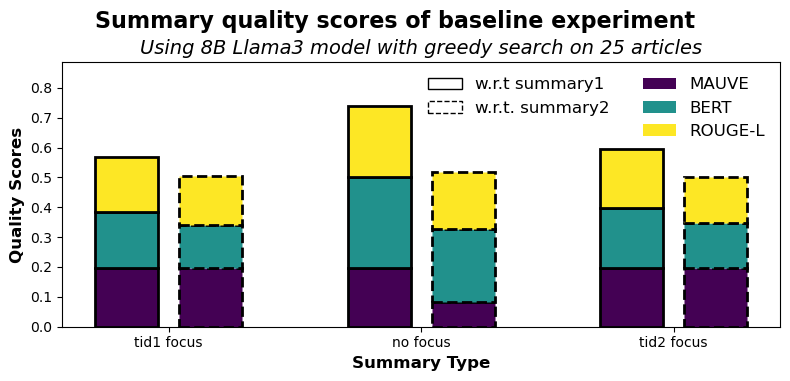

In [109]:
plot_baseline_experiment_results_exhaustive(experiment_results=experiment_results, score_type='quality')

# 4. Evaluate logits reweighting experiment results

## 4.1 Import logits reweighting experiment results

In [93]:
# Choose experiment between 'constant_shift', 'factor_scaling' and 'threshold_selection'
EXPERIMENT_NAME = 'threshold_selection'
FILE_NAME = 'threshold_selection_llama_8b_25_80_90_1'

In [94]:
experiment_results_file_path = os.path.join(data_dir, f'results_{EXPERIMENT_NAME}', f'{FILE_NAME}.json')
with open(experiment_results_file_path, 'r', encoding='utf-8') as f:
    experiment_results = json.load(f)
print(json.dumps(experiment_results, indent=4))

{
    "experiment_information": {
        "EXPERIMENT_CONFIG": {
            "experiment_name": "threshold_selection",
            "model_alias": "llama_8b"
        },
        "GENERATION_CONFIG": {
            "min_new_tokens": 80,
            "max_new_tokens": 90,
            "num_beams": 1,
            "do_sample": true,
            "top_p": 0.95,
            "top_k": 50
        },
        "DATASET_CONFIG": {
            "dataset_name": "newts_train",
            "num_articles": 25,
            "batch_size": 1,
            "num_workers": 0,
            "shuffle": false
        },
        "TOPICS_CONFIG": {
            "num_topic_words": 25,
            "min_phi_value": 0.001
        },
        "THRESHOLD_SELECTION_DICT": {
            "selection_thresholds": [
                1.0,
                0.2,
                0.05,
                0.01,
                0.005
            ],
            "topical_encouragement": 0.0
        }
    },
    "generated_summaries": [
        {
      

In [95]:
model = experiment_results['experiment_information']['EXPERIMENT_CONFIG']['model_alias']
num_articles = experiment_results['experiment_information']['DATASET_CONFIG']['num_articles']
experiment_name = experiment_results['experiment_information']['EXPERIMENT_CONFIG']['experiment_name']
experiment_name_pretty = experiment_name.replace('_', ' ')
model = experiment_results['experiment_information']['EXPERIMENT_CONFIG']['model_alias']
num_articles = experiment_results['experiment_information']['DATASET_CONFIG']['num_articles']
num_beams = experiment_results['experiment_information']['GENERATION_CONFIG']['num_beams']
beam_info = "beam search" if num_beams > 1 else "greedy search"
if experiment_name == 'constant_shift':
    factors = experiment_results['experiment_information']['CONSTANT_SHIFT_DICT']['shift_constants']
    factors_name = 'shift constants'
elif experiment_name == 'factor_scaling':
    factors = experiment_results['experiment_information']['FACTOR_SCALING_DICT']['scaling_factors']
    factors_name = 'scaling factors'
elif experiment_name == 'threshold_selection':
    factors = experiment_results['experiment_information']['THRESHOLD_SELECTION_DICT']['selection_thresholds']
    topical_encouragement = experiment_results['experiment_information']['THRESHOLD_SELECTION_DICT']['topical_encouragement']
    factors_name = 'selection thresholds'
else:
    print(f"Invalid experiment name: {experiment_name}")

In [96]:
def plot_logits_reweighting_experiment_results(avg_scores: dict, score_type: str, method: str):
    """
    Plot the average scores for different reweighting factors, selectable between topic scores and ROUGE scores.

    :param avg_scores: Dictionary of average scores with reweighting factors as keys.
    :param choice: String indicating whether to plot 'topic' or 'rouge'
    """
    labels = [f'{factor}' for factor in avg_scores.keys()]
    scores = [score for score in avg_scores.values()]
    colors = plt.cm.viridis(np.linspace(0, 1, len(scores)))

    # Plotting
    plt.figure(figsize=FIG_SIZE)
    plt.bar(x=labels, height=scores, color=colors, edgecolor='grey')
    plt.xlabel(xlabel=factors_name.capitalize(), fontweight='bold', fontsize=FONT_SIZE_LABEL)
    plt.suptitle(f'Summary {score_type} scores of {experiment_name_pretty} experiment', fontsize=FONT_SIZE_SUPTITLE, fontweight='bold', y=Y_SUBTITLE)
    plt.title(f'Using {MODEL_NAME_DICT[model]} model with {beam_info} on {num_articles} articles', fontsize=FONT_SIZE_TITLE, style='italic')
    if score_type == 'topic':
        plt.ylabel(f'Average {score_type} score', fontsize=FONT_SIZE_LABEL, fontweight='bold')
    elif score_type == 'quality':
        plt.ylabel(f'Average {METHOD_DICT[method]} score', fontsize=FONT_SIZE_LABEL, fontweight='bold')
    plt.tight_layout()
    plt.savefig(fname=f'../../data/plots/{experiment_name}/{score_type.lower()}_{method}_scores_{FILE_NAME}.pdf', dpi=DPI, format=PLOT_FORMAT)
    plt.show()

In [ ]:
# for score_type choose between: 'topic' or 'quality'
SCORE_TYPE = 'quality'
# if score_type is 'topic' choose between: 'stem', 'lemmatize', 'tokenize' and 'dict'
# if score_type is 'quality' choose between: 'mauve', 'bert', 'rougel', avg_rouge', 'rouge1', 'rouge2'
METHOD = 'bert'

In [ ]:
avg_scores = calculate_scores(experiment_results=experiment_results, score_type=SCORE_TYPE, method=METHOD,)
print(json.dumps(avg_scores, indent=4))

In [ ]:
plot_logits_reweighting_experiment_results(avg_scores=avg_scores, score_type=SCORE_TYPE, method=METHOD)

In [97]:
def plot_logits_reweighting_experiment_results_exhaustive(experiment_results: dict, score_type: str):
    """
    Plot the average scores for different reweighting factors, selectable between topic scores and ROUGE scores.
    :param experiment_results: Dictionary containing the scores for each method and focus type.
    :param score_type: String indicating whether to plot 'topic' or 'quality'.
    """
    score_type = score_type.lower()
    scores_data = {}
    if score_type == 'topic':
        methods = ['lemmatize', 'tokenize', 'dict']
    elif score_type == 'quality':
        methods = ['mauve', 'bert', 'rougeL']
    else:
        raise ValueError("Invalid choice for 'score_type', please select 'topic' or 'quality'.")
    
    for method in methods:
        scores_data[method] = calculate_scores(experiment_results=experiment_results, score_type=score_type, method=method)
    factors = [factor for factor in scores_data[methods[0]].keys()]
    labels = [f'{factor}' for factor in factors]

    plt.rcParams["figure.figsize"] = FIG_SIZE
    colors = plt.cm.viridis(np.linspace(0, 1, len(methods)))
    index = np.arange(len(factors))
    bar_width = 0.7
    bottom_heights = np.zeros(len(factors))
    for m, method in enumerate(methods):
        for i, factor in enumerate(factors):
            score = scores_data[method][factor]
            plt.bar(x=i, height=score, width=bar_width, bottom=bottom_heights[i],
                    label=f"{METHOD_DICT[method]} Score" if i == 0 else "", color=colors[m],
                    edgecolor='black', linewidth=1)
            bottom_heights[i] += score
    
    plt.ylabel(f'{score_type.capitalize()} Scores', fontsize=FONT_SIZE_LABEL, fontweight='bold')
    plt.suptitle(f'Summary {score_type} scores of {experiment_name_pretty} experiment', fontsize=FONT_SIZE_SUPTITLE, fontweight='bold', y=Y_SUBTITLE)
    plt.title(f'Using {MODEL_NAME_DICT[model]} model with {beam_info} on {num_articles} articles', fontsize=FONT_SIZE_TITLE, style='italic')
    
    plt.ylim(top=max(bottom_heights) * 1.2)
    plt.xlabel(xlabel=factors_name.capitalize(), fontweight='bold', fontsize=FONT_SIZE_LABEL)
    plt.xticks(ticks=index, labels=factors, fontsize=FONT_SIZE_TICKS)
    plt.legend(prop={'size': FONT_SIZE_LEGEND}, loc='upper center', ncol=3, frameon=False)
    plt.tight_layout()
    plt.savefig(fname=f'../../data/plots/{experiment_name}/{score_type.lower()}_exhaustive_{FILE_NAME}.pdf', dpi=DPI, format=PLOT_FORMAT)
    plt.show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


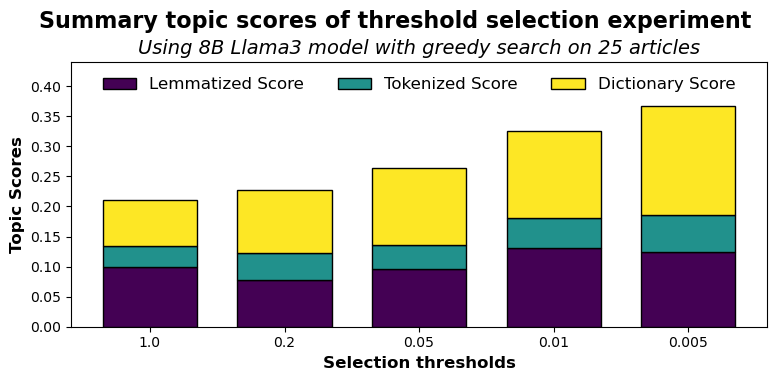

In [99]:
plot_logits_reweighting_experiment_results_exhaustive(experiment_results=experiment_results, score_type='topic')